<a href="https://colab.research.google.com/github/didinroych/python/blob/main/FoodModelUNSC256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt


In [ ]:
path = kagglehub.dataset_download("rkuo2000/uecfood256")
print("Path to dataset files:", path)

100%|██████████| 3.94G/3.94G [01:00<00:00, 70.2MB/s]

Extracting files...


cp: cannot stat 'path': No such file or directory
Path to dataset files: /root/.cache/kagglehub/datasets/rkuo2000/uecfood256/versions/1


In [ ]:
!cp -r /root/.cache/kagglehub/datasets/rkuo2000/uecfood256/versions/1 /content/dataset

In [ ]:
def load_bounding_boxes(data_dir):
    bounding_boxes = {}

    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        if not os.path.isdir(folder_path):
            continue

        bb_file = os.path.join(folder_path, 'bb_info.txt')

        if os.path.exists(bb_file):
            print(f"bb_info.txt ditemukan di folder {folder_name}")

            with open(bb_file, 'r') as file:
                folder_bounding_boxes = {}
                for line in file:
                    parts = line.strip().split()

                    if parts[0] == 'img':
                        continue

                    img_num, x1, y1, x2, y2 = map(int, parts)
                    folder_bounding_boxes[img_num] = (x1, y1, x2, y2)

                bounding_boxes[folder_name] = folder_bounding_boxes
        else:
            print(f"bb_info.txt tidak ditemukan di folder {folder_name}")

    return bounding_boxes

def crop_and_save_images(data_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_bounding_boxes = load_bounding_boxes(data_dir)

    for category, bounding_boxes in all_bounding_boxes.items():
        category_path = os.path.join(data_dir, category)

        category_output_path = os.path.join(output_dir, category)
        os.makedirs(category_output_path, exist_ok=True)

        for img_num, bbox in bounding_boxes.items():
            img_path = os.path.join(category_path, f"{img_num}.jpg")

            if not os.path.exists(img_path):
                print(f"Gambar {img_num}.JPG tidak ditemukan di folder {category}")
                continue

            x1, y1, x2, y2 = bbox
            image = cv2.imread(img_path)
            if image is None:
                print(f"Gagal membaca gambar {img_num}.JPG di folder {category}")
                continue

            cropped_image = image[y1:y2, x1:x2]

            output_img_path = os.path.join(category_output_path, f"{img_num}.JPG")
            cv2.imwrite(output_img_path, cropped_image)
            print(f"Gambar {img_num}.JPG berhasil disimpan ke {output_img_path}")

# Path data dan output
data_dir = "/content/dataset/1/UECFOOD256"
output_dir = "/content/dataset/processed_UECFOOD256"

crop_and_save_images(data_dir, output_dir)


Streaming output truncated to the last 5000 lines.
Gambar 12552.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/12552.JPG
Gambar 12553.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/12553.JPG
Gambar 12554.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/12554.JPG
Gambar 12555.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/12555.JPG
Gambar 12556.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/12556.JPG
Gambar 12557.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/12557.JPG
Gambar 13626.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/13626.JPG
Gambar 13889.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/13889.JPG
Gambar 13965.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/13965.JPG
Gambar 14047.JPG berhasil disimpan ke /content/dataset/processed_UECFOOD256/94/14047.JPG
Gambar 14210.JPG berhasil disimpan ke /content/dataset/proc

In [ ]:
import shutil

source_dir = output_dir
subset_dir = '/content/dataset/newdata'

os.makedirs(subset_dir, exist_ok=True)

classes = sorted(os.listdir(source_dir))[:4]

for class_name in classes:
    class_path = os.path.join(source_dir, class_name)
    target_path = os.path.join(subset_dir, class_name)
    shutil.copytree(class_path, target_path)

print("Subset dataset selesai dibuat.")


Subset dataset selesai dibuat.


In [ ]:
def count_images_in_folders(base_dir):
    folder_counts = {}
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_counts[folder_name] = num_images
    return folder_counts

base_directory = subset_dir
image_counts = count_images_in_folders(base_directory)

for folder, count in image_counts.items():
    print(f"Folder '{folder}' contains {count} images.")


Folder '100' contains 104 images.
Folder '10' contains 136 images.
Folder '101' contains 100 images.
Folder '1' contains 620 images.


In [ ]:

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    subset_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',  #
    subset='training'
)

val_data = datagen.flow_from_directory(
    subset_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 769 images belonging to 4 classes.
Found 191 images belonging to 4 classes.


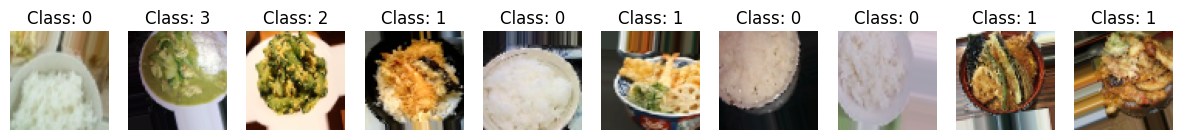

In [ ]:
images, labels = next(train_data)

# Define the number of images you want to visualize
num_images = 10
plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])  # Display the image
    plt.title(f"Class: {labels[i].argmax()}")  # Show class label
    plt.axis("off")  # Hide axis for cleaner look

plt.show()


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(64, 64, 3)),
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(4, activation='softmax')
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
    )

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,033,540 (61.16 MB)

 Trainable params: 16,033,540 (61.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.5505 - loss: 1.3040 - val_accuracy: 0.6492 - val_loss: 1.0798 - learning_rate: 5.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 138s 11s/step - accuracy: 0.6542 - loss: 1.0924 - val_accuracy: 0.6492 - val_loss: 1.0456 - learning_rate: 5.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 10s/step - accuracy: 0.6409 - loss: 1.0580 - val_accuracy: 0.6492 - val_loss: 1.0334 - learning_rate: 5.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 139s 11s/step - accuracy: 0.6620 - loss: 1.0146 - val_accuracy: 0.6492 - val_loss: 1.0356 - learning_rate: 5.0000e-04
Epoch 5/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - accuracy: 0.6734 - loss: 1.0225

KeyboardInterrupt: 